In [1]:
import torch

from torch.utils.data import DataLoader, Dataset


import pandas as pd
import numpy as np
from gmf import GMFEngine, GMF
from mlp import MLPEngine
from neumf import NeuMFEngine
from data import SampleGenerator
from metrics import MetronAtK

import copy

In [2]:


def evaluate_hit_ndcg(model, evaluate_data):    
    model.eval()
    with torch.no_grad():
        test_users, test_items = evaluate_data[0], evaluate_data[1]
        negative_users, negative_items = evaluate_data[2], evaluate_data[3]        
        test_scores = model(test_users, test_items)
        negative_scores = model(negative_users, negative_items)
        
        metron = MetronAtK(top_k=10)
        
        metron.subjects = [test_users.data.view(-1).tolist(),
                             test_items.data.view(-1).tolist(),
                             test_scores.data.view(-1).tolist(),
                             negative_users.data.view(-1).tolist(),
                             negative_items.data.view(-1).tolist(),
                             negative_scores.data.view(-1).tolist()]
    hit_ratio, ndcg = metron.cal_hit_ratio(), metron.cal_ndcg()
        
    
    return hit_ratio, ndcg


def eval_ce_loss(model, data_loader):
    total_loss = 0.0
    n_batches = 0
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            users, items, ratings = batch[0], batch[1], batch[2]
            ratings = ratings.float()
            ratings_pred = model(users, items)
            crit = torch.nn.BCELoss()
            loss = crit(ratings_pred.view(-1), ratings)

            total_loss += loss.item()
            n_batches += 1
    
    return total_loss / n_batches

In [3]:
ml1m_dir = 'data/ml-100k/u.data'
ml1m_rating = pd.read_csv(ml1m_dir, sep='\t', header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')
# Reindex
user_id = ml1m_rating[['uid']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))
ml1m_rating = pd.merge(ml1m_rating, user_id, on=['uid'], how='left')
item_id = ml1m_rating[['mid']].drop_duplicates()
item_id['itemId'] = np.arange(len(item_id))
ml1m_rating = pd.merge(ml1m_rating, item_id, on=['mid'], how='left')
ml1m_rating = ml1m_rating[['userId', 'itemId', 'rating', 'timestamp']]
print('Range of userId is [{}, {}]'.format(ml1m_rating.userId.min(), ml1m_rating.userId.max()))
print('Range of itemId is [{}, {}]'.format(ml1m_rating.itemId.min(), ml1m_rating.itemId.max()))

Range of userId is [0, 942]
Range of itemId is [0, 1681]


In [4]:
num_users = len(ml1m_rating.userId.unique())
num_items = len(ml1m_rating.itemId.unique())

gmf_config = {
              'num_users': num_users,
              'num_items': num_items,
              'latent_dim': 10,
              'num_negative': 5,
              'l2_regularization': 0, # 0.01
              'use_cuda': False,
              'device_id': 0,
              'model_dir':'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}





## federated training

In [5]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        return self.dataset[self.idxs[item]]


class LocalUpdate:
    def __init__(self, model_global, dataset, user_id):
        idxs = torch.where(dataset.user_tensor == user_id)[0]
        self.local_dataset = DatasetSplit(dataset, idxs)
        self.num_local = len(self.local_dataset)        
        self.local_model = copy.deepcopy(model_global)
        self.user_id = user_id
        
        
    def train(self, lr, epoches_local, local_batch_size):
        local_data_loader = DataLoader(self.local_dataset, 
                                       batch_size=local_batch_size, 
                                       shuffle=True)
        
        self.local_model.train()
        opt = torch.optim.Adam(self.local_model.parameters(), lr=lr)
        for ep_local in range(epoches_local):
            t_loss = 0.0
            n_batch = 0
            for users, items, ratings in local_data_loader:
                opt.zero_grad()
                ratings = ratings.float()
                ratings_pred = self.local_model(users, items).view(-1)
                
                crit = torch.nn.BCELoss()
                loss = crit(ratings_pred, ratings)
                loss.backward()
                opt.step()
                
                t_loss += loss.item()
                n_batch += 1
            
            if (ep_local + 1) % 100  == 0:
                print("user", self.user_id, "ep_local", ep_local, t_loss/n_batch)
        
        return t_loss/n_batch


In [72]:
sample_generator = SampleGenerator(ratings=ml1m_rating)

model_global = GMF(gmf_config)

# keys of user and item embeddings in the model state dict
k_u, k_i = 'embedding_user.weight', 'embedding_item.weight'


In [73]:
# def train_fedavg(model_global, sample_generator):
frac = 0.1
epoches_local = 3
local_lr = 1e-2
act_samp = False
act_agg = False
n_clusters = 5

hit_ratio_hist, ndcg_hist = [], []
for epoch in range(500):
    train_loader = sample_generator.instance_a_train_loader(num_negatives=gmf_config['num_negative'], 
                                                            batch_size=1024)
    train_dataset = train_loader.dataset
    evaluate_data = sample_generator.evaluate_data

    if epoch > 5:
        act_samp = True
        act_agg = True

    # sample users    
    if act_samp:
        # active sampling
        idxs_users = []
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(model_global.state_dict()[k_u].numpy())
        for c in range(n_clusters):
            c_idxs = np.where(kmeans.labels_ == c)[0]
            sel = np.random.choice(c_idxs, max(int(frac * len(c_idxs)), 1))            
            idxs_users.append(sel)

        idxs_users = np.concatenate(idxs_users)
        m = len(idxs_users)
        
    else:
        m = max(int(frac * num_users), 1)
        idxs_users = np.random.choice(range(num_users), m, replace=False)

    w_locals, n_locals = [], []
    total_loss = 0.0
    for idx in idxs_users:        
        # local update
        local_update = LocalUpdate(model_global, train_dataset, user_id=idx)
        local_batch_size = int(len(local_update.local_dataset)*0.1)
        total_loss += local_update.train(local_lr, epoches_local, local_batch_size=local_batch_size)

        w_locals.append(copy.deepcopy(local_update.local_model.state_dict()))
        n_locals.append(local_update.num_local)
    
    # aggregated model
    w_avg = {}
    
    # global model of the previous round, i.e. w0
    w_global = model_global.state_dict()
    
    # aggregated user embeddings

    # update delegate embeddings
    # line 13 - 16 of Algorithm 3
    # user embedding: the k-th chosen user only updates its own user embedding
    w_avg[k_u] = copy.deepcopy(w_global[k_u])
    for k in range(m):
        w_avg[k_u][idxs_users[k]] = w_locals[k][k_u][idxs_users[k]]
    
    # updating subordinate user embeddings
    if act_agg:
        # active aggregation
        # cluster users
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(w_avg[k_u].numpy())
        
        # line 19 - 25 of Algorithm 3
        # for each cluster c, compute the average user-embedding updates of the delegates in c
        # results saved in avg_cluster_update
        dim_emb = w_avg[k_u].shape[1]
        avg_cluster_update = torch.zeros(n_clusters, dim_emb)
        
        # number of delegates in each cluster
        num_cluster_dels = torch.zeros(n_clusters)
        cluster_labels = kmeans.labels_
        for k in range(len(idxs_users)):
            c = cluster_labels[idxs_users[k]]
            avg_cluster_update[c] += w_locals[k][k_u][idxs_users[k]] - w_global[k_u][idxs_users[k]]
            num_cluster_dels[c] += 1
        
        for c in range(n_clusters):
            avg_cluster_update[c] /= num_cluster_dels[c]


        # line 26 - 30 of Algorithm 3
        # apply the cluster average updates to all of the subordinate cluster members
        for k in range(num_users):
            c = cluster_labels[k]
            if k in idxs_users:
                continue
            w_avg[k_u][k] += avg_cluster_update[c] * np.exp(-epoch)
            
    # contribution of each user to all items, measured by L1 distance between the 
    # local item embeddings to the global item embeddings
    # line 6 - 9 of Algorithm 3
    contrib = torch.zeros(m, num_items)
    for k in range(m):
        contrib[k] = (w_global[k_i] - w_locals[k][k_i]).abs().sum(1)

    eps = 1e-10
    contrib = contrib / (contrib.sum(0) + eps)
    
    # aggregate item embeddings: line 10 - 12 of Algorithm 3
    w_avg[k_i] = copy.deepcopy(w_global[k_i])
    for i in range(num_items):
        if contrib[:, i].sum() == 0:
            # item i is not updated by any chosen user, keep the original embedding
            continue
        
        w_avg[k_i][i] *= 0
        for k in range(m):
            # aggregated embedding of item i: weighted by the contribution of each user
            w_avg[k_i][i] += w_locals[k][k_i][i] * contrib[k][i]
    
    # aggregate other model parameters
    # line 2 - 3 of algorithm 3
    n_locals = np.array(n_locals, dtype=np.float64)
    n_locals /= n_locals.sum()
    for k in w_global.keys():
        if k != k_u and k != k_i:
            w_avg[k] = 0.0
            for i in range(len(w_locals)):
                w_avg[k] += w_locals[i][k] * n_locals[i]
    

    model_global.load_state_dict(w_avg)
    hit_ratio, ndcg = evaluate_hit_ndcg(model_global, evaluate_data)

    total_loss_global = eval_ce_loss(model_global, train_loader)
    print(epoch, "local_loss", total_loss/m, "total_loss_global", total_loss_global, 
          "hit_ratio", hit_ratio, "ndcg", ndcg)
    
    hit_ratio_hist.append(hit_ratio)
    ndcg_hist.append(ndcg)





/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


0 local_loss 0.663326524852323 total_loss_global 0.6912685837885189 hit_ratio 0.21951219512195122 ndcg 0.09632920728861612
1 local_loss 0.5764964159556467 total_loss_global 0.5982982579894403 hit_ratio 0.21845174973488865 ndcg 0.0959776463216932
2 local_loss 0.5113067583834872 total_loss_global 0.531634998403605 hit_ratio 0.2014846235418876 ndcg 0.09284477505724752
3 local_loss 0.4658480129285753 total_loss_global 0.49107971725898847 hit_ratio 0.21739130434782608 ndcg 0.09794896855423765
4 local_loss 0.44437708286010114 total_loss_global 0.4668691906686904 hit_ratio 0.19936373276776245 ndcg 0.09113253209554993
5 local_loss 0.42745017415521475 total_loss_global 0.4567607274974685 hit_ratio 0.19618239660657477 ndcg 0.08985978220888198


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


6 local_loss 0.42346368456340366 total_loss_global 0.45498978419681424 hit_ratio 0.18875927889713678 ndcg 0.08895494644679729


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


7 local_loss 0.42334979607800954 total_loss_global 0.4552708287657641 hit_ratio 0.2014846235418876 ndcg 0.09091303546785352


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


8 local_loss 0.42045136284333456 total_loss_global 0.4557078558175781 hit_ratio 0.2014846235418876 ndcg 0.09201754290202184


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


9 local_loss 0.4212866134087561 total_loss_global 0.4581046150083591 hit_ratio 0.20042417815482502 ndcg 0.09422146917411248


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


10 local_loss 0.41735951669298343 total_loss_global 0.45677991962884257 hit_ratio 0.20784729586426298 ndcg 0.09511991146844216


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


11 local_loss 0.41118849047529593 total_loss_global 0.45604181653866466 hit_ratio 0.20996818663838812 ndcg 0.0954336026716499


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


12 local_loss 0.41378331816361363 total_loss_global 0.45620020428951347 hit_ratio 0.21208907741251326 ndcg 0.09745639723383738


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


13 local_loss 0.41112882422629327 total_loss_global 0.4567441686397986 hit_ratio 0.2205726405090138 ndcg 0.10234305224251161


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


14 local_loss 0.4072996184973435 total_loss_global 0.4570289395249444 hit_ratio 0.21527041357370094 ndcg 0.10121387278143594


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


15 local_loss 0.40783210817436755 total_loss_global 0.45938611333218377 hit_ratio 0.23647932131495228 ndcg 0.10871695232516106


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


16 local_loss 0.3942457264738355 total_loss_global 0.4587497515235218 hit_ratio 0.23435843054082714 ndcg 0.10967223853604623


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


17 local_loss 0.40238407136961624 total_loss_global 0.4585935243641038 hit_ratio 0.24708377518557795 ndcg 0.11744920175239205


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


18 local_loss 0.3987609002695018 total_loss_global 0.4589951501553317 hit_ratio 0.2545068928950159 ndcg 0.12100365357106557


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


19 local_loss 0.39808719950496196 total_loss_global 0.4589281649474638 hit_ratio 0.2651113467656416 ndcg 0.12498345021596804


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


20 local_loss 0.3914160947819707 total_loss_global 0.45954664469585976 hit_ratio 0.26299045599151644 ndcg 0.12515080953064217


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


21 local_loss 0.3865742353094288 total_loss_global 0.46095185630703134 hit_ratio 0.2767762460233298 ndcg 0.13143513587894223


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


22 local_loss 0.3837817953332612 total_loss_global 0.45932489125740916 hit_ratio 0.2831389183457052 ndcg 0.134764274619516


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


23 local_loss 0.38220868770575706 total_loss_global 0.45928665492908066 hit_ratio 0.2873806998939555 ndcg 0.13643884857895863


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


24 local_loss 0.38408690990563565 total_loss_global 0.45988409890570453 hit_ratio 0.28844114528101805 ndcg 0.138776230032597


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


25 local_loss 0.3688963960789938 total_loss_global 0.45705819483878485 hit_ratio 0.2990455991516437 ndcg 0.14541789198460628


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


26 local_loss 0.36296150218822854 total_loss_global 0.45999018696622473 hit_ratio 0.30328738069989397 ndcg 0.1484896741545851


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


27 local_loss 0.3722929531502217 total_loss_global 0.45963665612183013 hit_ratio 0.30434782608695654 ndcg 0.15378625828302075


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


28 local_loss 0.3600803861666929 total_loss_global 0.459527207015919 hit_ratio 0.3244962884411453 ndcg 0.1613341771187991


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


29 local_loss 0.36501713846172845 total_loss_global 0.45787862302309057 hit_ratio 0.32343584305408274 ndcg 0.1643920870456608


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


30 local_loss 0.3569176448235561 total_loss_global 0.4595369896667139 hit_ratio 0.32873806998939553 ndcg 0.16886397137748


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


31 local_loss 0.35349031532102304 total_loss_global 0.45793412889958246 hit_ratio 0.32873806998939553 ndcg 0.17115286828726034


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


32 local_loss 0.35563292796668333 total_loss_global 0.45751977023282275 hit_ratio 0.3340402969247084 ndcg 0.1731529494675947


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


33 local_loss 0.34551201808034426 total_loss_global 0.45711725252630786 hit_ratio 0.34676564156945916 ndcg 0.1765500532815696


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


34 local_loss 0.35335353489287885 total_loss_global 0.4561636892633061 hit_ratio 0.35100742311770944 ndcg 0.17947149193104986


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


35 local_loss 0.353100059570914 total_loss_global 0.457546842539372 hit_ratio 0.3584305408271474 ndcg 0.18813216754070808


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


36 local_loss 0.34073504817548333 total_loss_global 0.45647546900324076 hit_ratio 0.37009544008483564 ndcg 0.19358981899478978


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


37 local_loss 0.3522788786605413 total_loss_global 0.45169403338596453 hit_ratio 0.3743372216330859 ndcg 0.19720686466972445


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


38 local_loss 0.3450823161927726 total_loss_global 0.4516304296901427 hit_ratio 0.37751855779427357 ndcg 0.1981962914339478


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


39 local_loss 0.33700784270751194 total_loss_global 0.4490496356187712 hit_ratio 0.3806998939554613 ndcg 0.20370298476053045


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


40 local_loss 0.33825333516609357 total_loss_global 0.44992007425442826 hit_ratio 0.3828207847295864 ndcg 0.2049727840373902


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


41 local_loss 0.3288498653319809 total_loss_global 0.44678002149636076 hit_ratio 0.3987274655355249 ndcg 0.2114260077296247


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


42 local_loss 0.33020012079012906 total_loss_global 0.44345086623181984 hit_ratio 0.40721102863202546 ndcg 0.21630750405919344


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


43 local_loss 0.3415958751819202 total_loss_global 0.4340728506984481 hit_ratio 0.4135737009544008 ndcg 0.21978564621304467


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


44 local_loss 0.3350945382352309 total_loss_global 0.4357189551483128 hit_ratio 0.4252386002120891 ndcg 0.22553441885433514


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


45 local_loss 0.3277092117205144 total_loss_global 0.4361056112996888 hit_ratio 0.42948038176033937 ndcg 0.22749780895518254


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


46 local_loss 0.3230740821298227 total_loss_global 0.433253556284765 hit_ratio 0.4369034994697773 ndcg 0.23257530618185795


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


47 local_loss 0.327990487545029 total_loss_global 0.4313166199986167 hit_ratio 0.43796394485683987 ndcg 0.23418741380259744


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


48 local_loss 0.32743203730686843 total_loss_global 0.42900539029280615 hit_ratio 0.4411452810180276 ndcg 0.23624828148012883


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


49 local_loss 0.3247827809869678 total_loss_global 0.425978451710765 hit_ratio 0.44220572640509015 ndcg 0.24015833913422277


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


50 local_loss 0.33361397919911356 total_loss_global 0.42342434764523923 hit_ratio 0.4528101802757158 ndcg 0.2478922277016115


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


51 local_loss 0.31750982069472955 total_loss_global 0.4204496576638312 hit_ratio 0.45068928950159065 ndcg 0.2485707347849075


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


52 local_loss 0.3170256821352622 total_loss_global 0.42039396712578925 hit_ratio 0.46129374337221635 ndcg 0.2509414333801089


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


53 local_loss 0.31651845123712913 total_loss_global 0.4189349151827177 hit_ratio 0.4634146341463415 ndcg 0.25493776127809015


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


54 local_loss 0.3213734469873456 total_loss_global 0.41566208476864325 hit_ratio 0.4634146341463415 ndcg 0.2568216707464217


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


55 local_loss 0.31859380612757215 total_loss_global 0.41073718189987996 hit_ratio 0.4708377518557794 ndcg 0.2591068812025246


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


56 local_loss 0.31857933210238465 total_loss_global 0.41156057723623135 hit_ratio 0.47613997879109227 ndcg 0.26248124494723823


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


57 local_loss 0.3195625204637116 total_loss_global 0.4089317212006311 hit_ratio 0.4814422057264051 ndcg 0.2666849451138521


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


58 local_loss 0.30966314656272137 total_loss_global 0.41052545578877814 hit_ratio 0.48462354188759277 ndcg 0.2671362217437527


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


59 local_loss 0.3135237519780225 total_loss_global 0.4119786287749286 hit_ratio 0.4899257688229056 ndcg 0.2700380125621922


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


60 local_loss 0.3161843935428959 total_loss_global 0.4067471433629678 hit_ratio 0.4973488865323436 ndcg 0.27504775575414664


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


61 local_loss 0.320799253131914 total_loss_global 0.40187665019921714 hit_ratio 0.5047720042417816 ndcg 0.27796101478404417


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


62 local_loss 0.3059846435541015 total_loss_global 0.3992695220058428 hit_ratio 0.5047720042417816 ndcg 0.27884226176631893


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


63 local_loss 0.31276545100771774 total_loss_global 0.39326960458812943 hit_ratio 0.5068928950159067 ndcg 0.28305606441699294


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


64 local_loss 0.3080135896489055 total_loss_global 0.3923601530710309 hit_ratio 0.5111346765641569 ndcg 0.2823360060243721


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


65 local_loss 0.31209664900489015 total_loss_global 0.39194585226489015 hit_ratio 0.5100742311770944 ndcg 0.28362375515663707


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


66 local_loss 0.3037308790936759 total_loss_global 0.3901472399444055 hit_ratio 0.5206786850477201 ndcg 0.28828575073505125


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


67 local_loss 0.3026231508581022 total_loss_global 0.3879260892712106 hit_ratio 0.5227995758218452 ndcg 0.2887666325988817


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


68 local_loss 0.3076950533992864 total_loss_global 0.38732935685709297 hit_ratio 0.5164369034994698 ndcg 0.2895176395311145


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


69 local_loss 0.32467236218517526 total_loss_global 0.3839340329990945 hit_ratio 0.5249204665959704 ndcg 0.29232015691652835


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


70 local_loss 0.3034514250084467 total_loss_global 0.3843563380114183 hit_ratio 0.5259809119830329 ndcg 0.2915932937762154


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


71 local_loss 0.3028273542858882 total_loss_global 0.3837082480399416 hit_ratio 0.5302226935312832 ndcg 0.2957931895894886


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


72 local_loss 0.30584172293633133 total_loss_global 0.38199774343873055 hit_ratio 0.5334040296924708 ndcg 0.29785891883178633


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


73 local_loss 0.30846473105111916 total_loss_global 0.37999880447239964 hit_ratio 0.5291622481442205 ndcg 0.29698487441628063


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


74 local_loss 0.30378639312173894 total_loss_global 0.38004793090787486 hit_ratio 0.5291622481442205 ndcg 0.29879090720675194


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


75 local_loss 0.3055048682986379 total_loss_global 0.3768037075943052 hit_ratio 0.5344644750795334 ndcg 0.3000277421659568


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


76 local_loss 0.3120400050896909 total_loss_global 0.3779347655900374 hit_ratio 0.5376458112407211 ndcg 0.30044267628469495


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


77 local_loss 0.3073071900265381 total_loss_global 0.37510812508259705 hit_ratio 0.5418875927889714 ndcg 0.30106665516099396


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


78 local_loss 0.2995176019893212 total_loss_global 0.37282136995698006 hit_ratio 0.5471898197242842 ndcg 0.3035068804738872


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


79 local_loss 0.3033311285100373 total_loss_global 0.372892266552953 hit_ratio 0.542948038176034 ndcg 0.30438199720305503


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


80 local_loss 0.30002203747361406 total_loss_global 0.37017324910516786 hit_ratio 0.5524920466595971 ndcg 0.3074957877417397


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


81 local_loss 0.31187607433887266 total_loss_global 0.37007271756198445 hit_ratio 0.5546129374337222 ndcg 0.31071715852602694


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


82 local_loss 0.30381760603100394 total_loss_global 0.36959329468042634 hit_ratio 0.5546129374337222 ndcg 0.3117287337035309


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


83 local_loss 0.2953364923290849 total_loss_global 0.3672251318182264 hit_ratio 0.5546129374337222 ndcg 0.3116858248664011


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


84 local_loss 0.31340654753483493 total_loss_global 0.36487820349543926 hit_ratio 0.5652173913043478 ndcg 0.3158936932534447


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


85 local_loss 0.30261996187832907 total_loss_global 0.36259521946644413 hit_ratio 0.5609756097560976 ndcg 0.31495820417719816


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


86 local_loss 0.30530623479492297 total_loss_global 0.36172725278210927 hit_ratio 0.5641569459172853 ndcg 0.31541088710478177


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


87 local_loss 0.3164039579932945 total_loss_global 0.36154718817614034 hit_ratio 0.5683987274655355 ndcg 0.3170063976508013


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


88 local_loss 0.308915904341284 total_loss_global 0.3617734073977052 hit_ratio 0.5662778366914104 ndcg 0.3174818172243853


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


89 local_loss 0.30639449588755674 total_loss_global 0.3620954575514014 hit_ratio 0.574761399787911 ndcg 0.319579036991341


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


90 local_loss 0.2982737786610878 total_loss_global 0.36076156659093456 hit_ratio 0.5768822905620361 ndcg 0.3233349377219514


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


91 local_loss 0.2882699935590024 total_loss_global 0.36025409197848346 hit_ratio 0.5779427359490986 ndcg 0.32376543631720284


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


92 local_loss 0.30388166934496585 total_loss_global 0.359023727104709 hit_ratio 0.5779427359490986 ndcg 0.32285201113582207


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


93 local_loss 0.29293038721134024 total_loss_global 0.35834950224052403 hit_ratio 0.5779427359490986 ndcg 0.3239471821932256


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


94 local_loss 0.29625732912921265 total_loss_global 0.35800082384001164 hit_ratio 0.5790031813361611 ndcg 0.3233030755037686


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


95 local_loss 0.3053860792980378 total_loss_global 0.35836374369833024 hit_ratio 0.574761399787911 ndcg 0.3237970404073773


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


96 local_loss 0.2955107625901952 total_loss_global 0.35531449969377044 hit_ratio 0.5779427359490986 ndcg 0.32636284099100615


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


97 local_loss 0.2983931601163471 total_loss_global 0.35329849892352 hit_ratio 0.584305408271474 ndcg 0.32893079029277744


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


98 local_loss 0.2987893840813413 total_loss_global 0.3513548407517694 hit_ratio 0.5832449628844114 ndcg 0.3301926999060873


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


99 local_loss 0.29450474899159124 total_loss_global 0.34919076634766516 hit_ratio 0.5874867444326617 ndcg 0.331157327207799


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


100 local_loss 0.2947746752284264 total_loss_global 0.3478762214544923 hit_ratio 0.5885471898197243 ndcg 0.3313378527604018


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


101 local_loss 0.29072756145385065 total_loss_global 0.3473224701446428 hit_ratio 0.5927889713679746 ndcg 0.33386914209748914


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


102 local_loss 0.29464013954111945 total_loss_global 0.3463397201490484 hit_ratio 0.5906680805938495 ndcg 0.3327564187101288


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


103 local_loss 0.303436986876195 total_loss_global 0.3458311431071434 hit_ratio 0.5885471898197243 ndcg 0.3332889480557501


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


104 local_loss 0.2957353054583552 total_loss_global 0.344438975731395 hit_ratio 0.5927889713679746 ndcg 0.3352872244187615


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


105 local_loss 0.2904914945334549 total_loss_global 0.3443308664989143 hit_ratio 0.5906680805938495 ndcg 0.33354882900619537


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


106 local_loss 0.2937652091334643 total_loss_global 0.3422997141971851 hit_ratio 0.5959703075291622 ndcg 0.3367201095280733


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


107 local_loss 0.2943709278224292 total_loss_global 0.34278877543705466 hit_ratio 0.5991516436903499 ndcg 0.33718691008230095


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


108 local_loss 0.29383314443151143 total_loss_global 0.34282214849828235 hit_ratio 0.6033934252386002 ndcg 0.33885605918051803


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


109 local_loss 0.29243746163993495 total_loss_global 0.3406080194266446 hit_ratio 0.601272534464475 ndcg 0.3377969549864245


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


110 local_loss 0.2939218914212673 total_loss_global 0.34002605937228964 hit_ratio 0.6076352067868505 ndcg 0.341316733383498


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


111 local_loss 0.2953448350281834 total_loss_global 0.33994045668953254 hit_ratio 0.6044538706256628 ndcg 0.3423421338343656


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


112 local_loss 0.29243356369577206 total_loss_global 0.3387297930487667 hit_ratio 0.6065747613997879 ndcg 0.34391029972526377


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


113 local_loss 0.29585895221152375 total_loss_global 0.3373899638857981 hit_ratio 0.6097560975609756 ndcg 0.34572768070502413


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


114 local_loss 0.303272237063392 total_loss_global 0.3363246899771403 hit_ratio 0.6055143160127253 ndcg 0.3451377120191718


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


115 local_loss 0.2934762684773509 total_loss_global 0.33558486025017426 hit_ratio 0.6129374337221634 ndcg 0.3454941027467546


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


116 local_loss 0.296099830830466 total_loss_global 0.3361511782401605 hit_ratio 0.6182396606574762 ndcg 0.34945229085892077


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


117 local_loss 0.293467860900624 total_loss_global 0.3342581096901951 hit_ratio 0.6214209968186638 ndcg 0.3492113614793066


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


118 local_loss 0.29263132932948227 total_loss_global 0.3344754305333156 hit_ratio 0.6214209968186638 ndcg 0.3505315476121224


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


119 local_loss 0.2916539594969111 total_loss_global 0.3340543334127088 hit_ratio 0.6171792152704135 ndcg 0.34925402085443774


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


120 local_loss 0.2857339368746597 total_loss_global 0.3337524590209101 hit_ratio 0.6182396606574762 ndcg 0.35127327090624205


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


121 local_loss 0.3024452626068781 total_loss_global 0.3324661674987839 hit_ratio 0.6246023329798516 ndcg 0.35312539494114326


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


122 local_loss 0.290308206188106 total_loss_global 0.33244365899985506 hit_ratio 0.6288441145281018 ndcg 0.3547830658666797


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


123 local_loss 0.2860407109201621 total_loss_global 0.33164922182613316 hit_ratio 0.6277836691410392 ndcg 0.3545112072673786


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


124 local_loss 0.2928981925438161 total_loss_global 0.33369982658072717 hit_ratio 0.6256627783669141 ndcg 0.3561987151897341


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


125 local_loss 0.29505709549467346 total_loss_global 0.3316392497433648 hit_ratio 0.623541887592789 ndcg 0.35589657032752736


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


126 local_loss 0.29094953823940256 total_loss_global 0.3307755945471601 hit_ratio 0.6320254506892895 ndcg 0.3568963852900464


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


127 local_loss 0.2893487682984824 total_loss_global 0.3305955503565514 hit_ratio 0.6299045599151644 ndcg 0.35835422358174285


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


128 local_loss 0.2890871518068824 total_loss_global 0.33133447180516545 hit_ratio 0.6299045599151644 ndcg 0.3600647146798687


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


129 local_loss 0.28160397592865716 total_loss_global 0.33007678830685183 hit_ratio 0.6394485683987274 ndcg 0.36211154720026983


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


130 local_loss 0.28736474670957735 total_loss_global 0.3298859237701265 hit_ratio 0.6394485683987274 ndcg 0.36176304585615265


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


131 local_loss 0.29107322673498126 total_loss_global 0.3294309940888016 hit_ratio 0.6383881230116649 ndcg 0.3638026985554646


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


132 local_loss 0.28330648589609797 total_loss_global 0.32798373247793333 hit_ratio 0.6362672322375398 ndcg 0.36219096673918894


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


133 local_loss 0.27840894442198905 total_loss_global 0.3279827797269247 hit_ratio 0.6394485683987274 ndcg 0.3632845252313362


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


134 local_loss 0.27800731714796695 total_loss_global 0.32777761069099176 hit_ratio 0.6405090137857901 ndcg 0.36554844482932186


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


135 local_loss 0.29851877871811466 total_loss_global 0.3271951491779386 hit_ratio 0.6352067868504772 ndcg 0.3648403741092621


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


136 local_loss 0.27664824783244873 total_loss_global 0.32609494279255763 hit_ratio 0.6415694591728526 ndcg 0.3674181740917546


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


137 local_loss 0.28774918278215916 total_loss_global 0.32652371029230076 hit_ratio 0.6373276776246023 ndcg 0.3663634860899107


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


138 local_loss 0.28462569808678617 total_loss_global 0.32557329366211224 hit_ratio 0.6383881230116649 ndcg 0.36627659143492547


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


139 local_loss 0.2879545778062169 total_loss_global 0.32356620301683264 hit_ratio 0.6415694591728526 ndcg 0.3690005750320671


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


140 local_loss 0.2799298684963065 total_loss_global 0.3238386072718543 hit_ratio 0.6426299045599152 ndcg 0.370076772620132


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


141 local_loss 0.2819914293037396 total_loss_global 0.3238499184073351 hit_ratio 0.6468716861081655 ndcg 0.370490221222901


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


142 local_loss 0.2825706078442691 total_loss_global 0.32340539194220314 hit_ratio 0.6500530222693531 ndcg 0.37223367208590386


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


143 local_loss 0.27652456378840323 total_loss_global 0.32359141285776477 hit_ratio 0.6500530222693531 ndcg 0.37145220067540974


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


144 local_loss 0.2903831489431514 total_loss_global 0.32335839085857965 hit_ratio 0.6532343584305408 ndcg 0.3735592187467648


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


145 local_loss 0.2777043129695237 total_loss_global 0.3233814295413367 hit_ratio 0.6564156945917285 ndcg 0.3739967748475598


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


146 local_loss 0.28184561791482926 total_loss_global 0.322780576866383 hit_ratio 0.6553552492046659 ndcg 0.37534917668842654


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


147 local_loss 0.28642542011402705 total_loss_global 0.32229246694126557 hit_ratio 0.6542948038176034 ndcg 0.37613272135032993


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


148 local_loss 0.28008129549588745 total_loss_global 0.3223736203578581 hit_ratio 0.6585365853658537 ndcg 0.3756684964419575


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


149 local_loss 0.27662885048088026 total_loss_global 0.3227435130363077 hit_ratio 0.6553552492046659 ndcg 0.37860027830869103


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


150 local_loss 0.2792181462119425 total_loss_global 0.3221541467714228 hit_ratio 0.6553552492046659 ndcg 0.3781289433278508


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


151 local_loss 0.27150557768874356 total_loss_global 0.3217351524842175 hit_ratio 0.6542948038176034 ndcg 0.37867199540695734


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


152 local_loss 0.27689176152714273 total_loss_global 0.32138709680348787 hit_ratio 0.6532343584305408 ndcg 0.37887161622665116


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


153 local_loss 0.28028897367704936 total_loss_global 0.3205611161541405 hit_ratio 0.6585365853658537 ndcg 0.3806078847372531


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


154 local_loss 0.27781108034445295 total_loss_global 0.320254935044635 hit_ratio 0.6595970307529162 ndcg 0.38045594844002906


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


155 local_loss 0.27788765347588495 total_loss_global 0.3204785458705101 hit_ratio 0.6617179215270413 ndcg 0.38233975352438815


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


156 local_loss 0.2791939331860955 total_loss_global 0.319365261959332 hit_ratio 0.662778366914104 ndcg 0.3834487775243288


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


157 local_loss 0.27558607473627106 total_loss_global 0.3178947126290884 hit_ratio 0.6585365853658537 ndcg 0.38323369639112737


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


158 local_loss 0.27585212278907223 total_loss_global 0.3160231875675681 hit_ratio 0.6553552492046659 ndcg 0.3839570673198422


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


159 local_loss 0.2794895553302278 total_loss_global 0.31587739588881936 hit_ratio 0.6606574761399788 ndcg 0.38528076228790875


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


160 local_loss 0.262784223257023 total_loss_global 0.31447003738194856 hit_ratio 0.6574761399787911 ndcg 0.38326182113936436


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


161 local_loss 0.27561588726312547 total_loss_global 0.31475054376506967 hit_ratio 0.6595970307529162 ndcg 0.3841514043978391


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


162 local_loss 0.27619895294166635 total_loss_global 0.31450133223131477 hit_ratio 0.6585365853658537 ndcg 0.38448074906686547


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


163 local_loss 0.2661548390302608 total_loss_global 0.3142562206969204 hit_ratio 0.6595970307529162 ndcg 0.3849208278933353


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


164 local_loss 0.27077415727240894 total_loss_global 0.31356635130621274 hit_ratio 0.6585365853658537 ndcg 0.3833825679458303


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


165 local_loss 0.2746852382240825 total_loss_global 0.3138633631490389 hit_ratio 0.662778366914104 ndcg 0.3861851987473361


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


166 local_loss 0.26859405590442154 total_loss_global 0.31429179338497876 hit_ratio 0.6617179215270413 ndcg 0.38761500431901674


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


167 local_loss 0.27471570557025227 total_loss_global 0.31248519127217095 hit_ratio 0.6670201484623541 ndcg 0.38773942909487397


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


168 local_loss 0.276408343170592 total_loss_global 0.3124053857823042 hit_ratio 0.6659597030752916 ndcg 0.38893590607447415


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


169 local_loss 0.2669354805075876 total_loss_global 0.31177516802247746 hit_ratio 0.6680805938494168 ndcg 0.38965004790128316


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


170 local_loss 0.2849502212034811 total_loss_global 0.31126398294394686 hit_ratio 0.6702014846235419 ndcg 0.3907305253850199


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


171 local_loss 0.27813835010362226 total_loss_global 0.31203565945313433 hit_ratio 0.6659597030752916 ndcg 0.3902420573095081


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


172 local_loss 0.27239508489634573 total_loss_global 0.31368856570601666 hit_ratio 0.662778366914104 ndcg 0.3892014221171214


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


173 local_loss 0.27761807070511557 total_loss_global 0.31265153670475115 hit_ratio 0.6648992576882291 ndcg 0.39095081361025785


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


174 local_loss 0.26220370148672356 total_loss_global 0.3138866629740047 hit_ratio 0.6670201484623541 ndcg 0.39166662151932075


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


175 local_loss 0.26803201502538754 total_loss_global 0.3120094682899482 hit_ratio 0.6691410392364793 ndcg 0.39307953035111876


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


176 local_loss 0.2742686079740598 total_loss_global 0.31226195664290923 hit_ratio 0.6702014846235419 ndcg 0.39449973486569884


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


177 local_loss 0.268674986334628 total_loss_global 0.3125406528298908 hit_ratio 0.6691410392364793 ndcg 0.3944665510885408


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


178 local_loss 0.2590513646451907 total_loss_global 0.3128858605678644 hit_ratio 0.6702014846235419 ndcg 0.39204935112735817


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


179 local_loss 0.2696093139381586 total_loss_global 0.3125523092311754 hit_ratio 0.6691410392364793 ndcg 0.3926748258618212


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


180 local_loss 0.2581583778103513 total_loss_global 0.3123463810310922 hit_ratio 0.662778366914104 ndcg 0.38978906558372034


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


181 local_loss 0.2732080076178794 total_loss_global 0.3151213266147804 hit_ratio 0.6691410392364793 ndcg 0.391360185350217


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


182 local_loss 0.2820456123639362 total_loss_global 0.31260257133518354 hit_ratio 0.6702014846235419 ndcg 0.39307988638080543


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


183 local_loss 0.2677337615809345 total_loss_global 0.3109522509595408 hit_ratio 0.6712619300106044 ndcg 0.39400781664408346


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


184 local_loss 0.272044286805227 total_loss_global 0.3102853143789682 hit_ratio 0.6702014846235419 ndcg 0.39339472434989203


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


185 local_loss 0.2828538735151905 total_loss_global 0.3092180409960821 hit_ratio 0.672322375397667 ndcg 0.393469170384045


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


186 local_loss 0.267582253518946 total_loss_global 0.30847603682806896 hit_ratio 0.679745493107105 ndcg 0.39680745755005337


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


187 local_loss 0.27203549934632115 total_loss_global 0.309142178645848 hit_ratio 0.6744432661717922 ndcg 0.3964320920131336


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


188 local_loss 0.2700381342386054 total_loss_global 0.3096441128988479 hit_ratio 0.672322375397667 ndcg 0.3970212452951853


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


189 local_loss 0.2621115531176954 total_loss_global 0.30829603993133503 hit_ratio 0.6765641569459173 ndcg 0.3969881154064733


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


190 local_loss 0.26404768599199124 total_loss_global 0.30754473784909603 hit_ratio 0.672322375397667 ndcg 0.39704412905701525


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


191 local_loss 0.2648572234006179 total_loss_global 0.3076001972267837 hit_ratio 0.6776246023329798 ndcg 0.39904474551305663


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


192 local_loss 0.26168712979327996 total_loss_global 0.3087023879800524 hit_ratio 0.6765641569459173 ndcg 0.3988722373840165


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


193 local_loss 0.2723610311704265 total_loss_global 0.30664115595325137 hit_ratio 0.6755037115588547 ndcg 0.3986423256447682


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


194 local_loss 0.25685705392190766 total_loss_global 0.30579266557389817 hit_ratio 0.6765641569459173 ndcg 0.3994578640445902


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


195 local_loss 0.26113630481235467 total_loss_global 0.30629971028400166 hit_ratio 0.6776246023329798 ndcg 0.3995283031507633


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


196 local_loss 0.25556179881998364 total_loss_global 0.30638603417270155 hit_ratio 0.6786850477200425 ndcg 0.4001153722543405


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


197 local_loss 0.26881147858175075 total_loss_global 0.3065044033034943 hit_ratio 0.6786850477200425 ndcg 0.4000678351320785


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


198 local_loss 0.2726036383542177 total_loss_global 0.30585067828222723 hit_ratio 0.6786850477200425 ndcg 0.4013798036689735


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


199 local_loss 0.26560457829688233 total_loss_global 0.30662079201610487 hit_ratio 0.6755037115588547 ndcg 0.40087126994207195


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


200 local_loss 0.26623585127883925 total_loss_global 0.30453225406024625 hit_ratio 0.679745493107105 ndcg 0.4004366446645947


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


201 local_loss 0.26032491587875445 total_loss_global 0.30472966333572304 hit_ratio 0.6839872746553552 ndcg 0.40221620183038964


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


202 local_loss 0.2705561083414787 total_loss_global 0.30571666570210415 hit_ratio 0.6850477200424178 ndcg 0.4042288442597871


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


203 local_loss 0.27336192490402317 total_loss_global 0.30555946329887473 hit_ratio 0.6882290562036055 ndcg 0.4055856572927076


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


204 local_loss 0.2582112194326419 total_loss_global 0.30416865900748774 hit_ratio 0.6871686108165429 ndcg 0.40493749797856543


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


205 local_loss 0.2506733831003484 total_loss_global 0.3028972670307668 hit_ratio 0.6850477200424178 ndcg 0.4049054900086192


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


206 local_loss 0.2570593709533967 total_loss_global 0.3016280299517456 hit_ratio 0.6839872746553552 ndcg 0.40456721625421715


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


207 local_loss 0.2750640788446862 total_loss_global 0.30350056960024646 hit_ratio 0.6882290562036055 ndcg 0.4061144144612908


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


208 local_loss 0.2631682063075584 total_loss_global 0.30250490999262836 hit_ratio 0.6882290562036055 ndcg 0.40705011772351907


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


209 local_loss 0.2744721676424876 total_loss_global 0.30236394498208713 hit_ratio 0.6914103923647932 ndcg 0.40680995939237213


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


210 local_loss 0.26786140969001027 total_loss_global 0.30024869819516364 hit_ratio 0.6914103923647932 ndcg 0.4075408907770905


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


211 local_loss 0.2584377344763974 total_loss_global 0.30146412002547884 hit_ratio 0.6861081654294804 ndcg 0.4066035938934027


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


212 local_loss 0.25378027488509386 total_loss_global 0.30353382304182563 hit_ratio 0.689289501590668 ndcg 0.40748712999084563


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


213 local_loss 0.26102515999897635 total_loss_global 0.3033965147146875 hit_ratio 0.6924708377518558 ndcg 0.4081301853955201


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


214 local_loss 0.26395209880091114 total_loss_global 0.30112419614693386 hit_ratio 0.6935312831389183 ndcg 0.4080321988965425


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


215 local_loss 0.26624946073460565 total_loss_global 0.3012044437473284 hit_ratio 0.6903499469777307 ndcg 0.4079638129668364


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


216 local_loss 0.26322858860105885 total_loss_global 0.2997510176209698 hit_ratio 0.6956521739130435 ndcg 0.41096215088794985


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


217 local_loss 0.27350475837590676 total_loss_global 0.2995490703135472 hit_ratio 0.6903499469777307 ndcg 0.41126434059571043


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


218 local_loss 0.2660643441931126 total_loss_global 0.2980469083365393 hit_ratio 0.694591728525981 ndcg 0.4120144694973254


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


219 local_loss 0.25884738586795675 total_loss_global 0.30173078823110117 hit_ratio 0.7009544008483564 ndcg 0.41616512800735644


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


220 local_loss 0.2612354236075023 total_loss_global 0.3011587284466896 hit_ratio 0.6998939554612937 ndcg 0.41513356668784046


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


221 local_loss 0.25223998516865204 total_loss_global 0.30005232499921997 hit_ratio 0.694591728525981 ndcg 0.41247743866536835


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


222 local_loss 0.25371186923101685 total_loss_global 0.30051290801695824 hit_ratio 0.6998939554612937 ndcg 0.4147757555793153


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


223 local_loss 0.25435131768707053 total_loss_global 0.29971819787755893 hit_ratio 0.6977730646871686 ndcg 0.41422228596504335


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


224 local_loss 0.2544976411125045 total_loss_global 0.29984751023134143 hit_ratio 0.694591728525981 ndcg 0.41245193379526185


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


225 local_loss 0.2615265941939234 total_loss_global 0.2978412464081523 hit_ratio 0.6967126193001061 ndcg 0.41299171062252427


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


226 local_loss 0.2587526655976804 total_loss_global 0.29721551400043467 hit_ratio 0.694591728525981 ndcg 0.4124964785368752


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


227 local_loss 0.2609235554598566 total_loss_global 0.29737697767411164 hit_ratio 0.6977730646871686 ndcg 0.41308708821984264


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


228 local_loss 0.26837562112167124 total_loss_global 0.2968349738139499 hit_ratio 0.6977730646871686 ndcg 0.4148698889595127


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


229 local_loss 0.2500963399035804 total_loss_global 0.2964288887797042 hit_ratio 0.6935312831389183 ndcg 0.4143699690257351


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


230 local_loss 0.2665441162646804 total_loss_global 0.29760631464947523 hit_ratio 0.6977730646871686 ndcg 0.4148786938626861


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


231 local_loss 0.2558162776590348 total_loss_global 0.2961743505296527 hit_ratio 0.6988335100742312 ndcg 0.4151499528358444


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


232 local_loss 0.25688445207128197 total_loss_global 0.29697464037167226 hit_ratio 0.6956521739130435 ndcg 0.41530910992057757


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


233 local_loss 0.2582627788640353 total_loss_global 0.2968310539878379 hit_ratio 0.6956521739130435 ndcg 0.41352049400612995


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


234 local_loss 0.24819659492043739 total_loss_global 0.2964831722736769 hit_ratio 0.7009544008483564 ndcg 0.41538040215407773


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


235 local_loss 0.26132266019151645 total_loss_global 0.29542566292154604 hit_ratio 0.6977730646871686 ndcg 0.4149834460130798


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


236 local_loss 0.2540764394570548 total_loss_global 0.2966404246381146 hit_ratio 0.6998939554612937 ndcg 0.4149122947857653


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


237 local_loss 0.2624542707485321 total_loss_global 0.2971454830054777 hit_ratio 0.6998939554612937 ndcg 0.41412126543392186


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


238 local_loss 0.25544040062126105 total_loss_global 0.2966757289770343 hit_ratio 0.6977730646871686 ndcg 0.4154985905825467


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


239 local_loss 0.25683174988810753 total_loss_global 0.29711042054754117 hit_ratio 0.7009544008483564 ndcg 0.4156417390357798


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


240 local_loss 0.2517444031747432 total_loss_global 0.29534984717270596 hit_ratio 0.7009544008483564 ndcg 0.4166353184385436


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


241 local_loss 0.25457317891793796 total_loss_global 0.29309063942112323 hit_ratio 0.6998939554612937 ndcg 0.4166412559966199


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


242 local_loss 0.24968231288438278 total_loss_global 0.2925519140728985 hit_ratio 0.7051961823966065 ndcg 0.4194221760743228


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


243 local_loss 0.25311835290911977 total_loss_global 0.2936139619442764 hit_ratio 0.7020148462354189 ndcg 0.41925101785497915


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


244 local_loss 0.2613275771310439 total_loss_global 0.2930142067231738 hit_ratio 0.7073170731707317 ndcg 0.4204602853366448


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


245 local_loss 0.2517282810465252 total_loss_global 0.2941347016165876 hit_ratio 0.7062566277836692 ndcg 0.41974834977149417


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


246 local_loss 0.2535260117760024 total_loss_global 0.293831970831203 hit_ratio 0.7062566277836692 ndcg 0.42068145905001314


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


247 local_loss 0.27785112800282746 total_loss_global 0.2931324409997402 hit_ratio 0.7020148462354189 ndcg 0.41858358301049803


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


248 local_loss 0.24398942291865428 total_loss_global 0.29241926501314325 hit_ratio 0.7051961823966065 ndcg 0.41931093158492955


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


249 local_loss 0.2537758854742386 total_loss_global 0.2928293308631073 hit_ratio 0.7020148462354189 ndcg 0.41924742736542475


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


250 local_loss 0.2579147742779277 total_loss_global 0.29257278187960234 hit_ratio 0.7051961823966065 ndcg 0.4201052628682854


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


251 local_loss 0.2615307854386529 total_loss_global 0.2924082822418049 hit_ratio 0.7094379639448568 ndcg 0.42132730701141874


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


252 local_loss 0.24507886527992875 total_loss_global 0.29161256305527156 hit_ratio 0.7062566277836692 ndcg 0.42160215965552594


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


253 local_loss 0.2513539033588538 total_loss_global 0.2921625252383506 hit_ratio 0.7062566277836692 ndcg 0.4208538764255685


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


254 local_loss 0.25658106600401903 total_loss_global 0.2917588713247066 hit_ratio 0.7051961823966065 ndcg 0.4202071748640604


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


255 local_loss 0.26298580043539677 total_loss_global 0.2909355617277388 hit_ratio 0.7083775185577943 ndcg 0.4218155925397121


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


256 local_loss 0.2531818353383261 total_loss_global 0.2895111037665103 hit_ratio 0.7094379639448568 ndcg 0.42194687083614385


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


257 local_loss 0.25322371778490677 total_loss_global 0.2908563650567437 hit_ratio 0.7073170731707317 ndcg 0.42204160799856183


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


258 local_loss 0.2554395595228616 total_loss_global 0.29028748011732675 hit_ratio 0.7083775185577943 ndcg 0.42084918819647643


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


259 local_loss 0.251053052539974 total_loss_global 0.2913839633667941 hit_ratio 0.7062566277836692 ndcg 0.41964471882391924


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


260 local_loss 0.25393101036872556 total_loss_global 0.29127580840493233 hit_ratio 0.711558854718982 ndcg 0.4218286040336192


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


261 local_loss 0.2600218635159196 total_loss_global 0.28917612263647496 hit_ratio 0.7062566277836692 ndcg 0.42072604254023793


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


262 local_loss 0.2607529282659153 total_loss_global 0.2891086258904659 hit_ratio 0.711558854718982 ndcg 0.4232744253138961


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


263 local_loss 0.2592507775676927 total_loss_global 0.2891649806971394 hit_ratio 0.7094379639448568 ndcg 0.42486734385996855


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


264 local_loss 0.2565689220230889 total_loss_global 0.2880173886704568 hit_ratio 0.7104984093319194 ndcg 0.4242638600595924


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


265 local_loss 0.25936578567361035 total_loss_global 0.28832638586860104 hit_ratio 0.7104984093319194 ndcg 0.4229863169954211


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


266 local_loss 0.2600488873343573 total_loss_global 0.28747622717473265 hit_ratio 0.7126193001060446 ndcg 0.42472728439872093


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


267 local_loss 0.26031122008990143 total_loss_global 0.2872750978666821 hit_ratio 0.7104984093319194 ndcg 0.42438810688355355


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


268 local_loss 0.256548097828797 total_loss_global 0.28726596884083216 hit_ratio 0.7094379639448568 ndcg 0.4225302584300156


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


269 local_loss 0.24656888580513647 total_loss_global 0.28725894698280063 hit_ratio 0.7126193001060446 ndcg 0.42404245669438523


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


270 local_loss 0.24939084984539278 total_loss_global 0.28645243753459493 hit_ratio 0.7136797454931071 ndcg 0.4234196622511939


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


271 local_loss 0.24401942473698665 total_loss_global 0.28763600740190626 hit_ratio 0.7126193001060446 ndcg 0.4239160843814363


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


272 local_loss 0.2505921186175262 total_loss_global 0.2876969629485102 hit_ratio 0.7126193001060446 ndcg 0.42352344480081594


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


273 local_loss 0.24699422504041874 total_loss_global 0.28575374606656945 hit_ratio 0.711558854718982 ndcg 0.42425699963256036


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


274 local_loss 0.2538358769997064 total_loss_global 0.2868977351925254 hit_ratio 0.7126193001060446 ndcg 0.4225975559087035


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


275 local_loss 0.2482127806064349 total_loss_global 0.2863804723637855 hit_ratio 0.7094379639448568 ndcg 0.4225334677877107


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


276 local_loss 0.24091359332146184 total_loss_global 0.2871802741094218 hit_ratio 0.7136797454931071 ndcg 0.42593794541507457


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


277 local_loss 0.2547561880461611 total_loss_global 0.2871783706591995 hit_ratio 0.7179215270413574 ndcg 0.42811617381657735


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


278 local_loss 0.25814658518677686 total_loss_global 0.28599036663206434 hit_ratio 0.7083775185577943 ndcg 0.42462596394979113


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


279 local_loss 0.2515645929583377 total_loss_global 0.28612416826201387 hit_ratio 0.7147401908801697 ndcg 0.42639485240755043


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


280 local_loss 0.24813371764343212 total_loss_global 0.2866010101393455 hit_ratio 0.7104984093319194 ndcg 0.4256692253421784


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


281 local_loss 0.2509867177697325 total_loss_global 0.2854669593697776 hit_ratio 0.7062566277836692 ndcg 0.42506023551937344


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


282 local_loss 0.25188153699923344 total_loss_global 0.2860876309225358 hit_ratio 0.7136797454931071 ndcg 0.4266056621765967


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


283 local_loss 0.25914335592313076 total_loss_global 0.2856867308768471 hit_ratio 0.711558854718982 ndcg 0.42671824529324814


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


284 local_loss 0.25646906953810217 total_loss_global 0.28605034529342094 hit_ratio 0.7126193001060446 ndcg 0.42652779072845626


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


285 local_loss 0.2569322995906844 total_loss_global 0.28434064579092083 hit_ratio 0.7094379639448568 ndcg 0.42679487992862064


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


286 local_loss 0.25046013797308647 total_loss_global 0.2853290808744562 hit_ratio 0.7094379639448568 ndcg 0.42691685308126875


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


287 local_loss 0.25818566238091656 total_loss_global 0.28348992162235015 hit_ratio 0.7094379639448568 ndcg 0.42775748162128513


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


288 local_loss 0.2422419294667533 total_loss_global 0.28333858509584875 hit_ratio 0.7126193001060446 ndcg 0.42725116889946063


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


289 local_loss 0.2531137060224015 total_loss_global 0.2839016899235688 hit_ratio 0.7136797454931071 ndcg 0.4274965306887618


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


290 local_loss 0.2570653655490914 total_loss_global 0.2833479995007359 hit_ratio 0.7126193001060446 ndcg 0.4265579525297494


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


291 local_loss 0.2573180798886588 total_loss_global 0.28387653955904424 hit_ratio 0.7136797454931071 ndcg 0.42565558536133213


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


292 local_loss 0.24896622737262233 total_loss_global 0.2825563114245459 hit_ratio 0.7136797454931071 ndcg 0.4266759435256195


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


293 local_loss 0.25049937585195736 total_loss_global 0.2830015848969428 hit_ratio 0.7147401908801697 ndcg 0.4272919044661976


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


294 local_loss 0.2583787255956821 total_loss_global 0.28332755128610976 hit_ratio 0.7158006362672322 ndcg 0.4290340745065959


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


295 local_loss 0.23735281688468576 total_loss_global 0.2828268583434379 hit_ratio 0.7158006362672322 ndcg 0.42833928015225553


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


296 local_loss 0.25296874277145515 total_loss_global 0.28252005141080966 hit_ratio 0.7158006362672322 ndcg 0.427406523481717


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


297 local_loss 0.2504567603368069 total_loss_global 0.28280785533626807 hit_ratio 0.7158006362672322 ndcg 0.4283622982801015


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


298 local_loss 0.240096370360019 total_loss_global 0.2830570220383022 hit_ratio 0.7147401908801697 ndcg 0.43012566132091884


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


299 local_loss 0.24536405600406772 total_loss_global 0.28136580654142646 hit_ratio 0.721102863202545 ndcg 0.42953366230367773


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


300 local_loss 0.25395217668633213 total_loss_global 0.28248970695288783 hit_ratio 0.721102863202545 ndcg 0.4292032136158886


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


301 local_loss 0.24595084769744255 total_loss_global 0.28327810566827477 hit_ratio 0.7158006362672322 ndcg 0.4284456602771939


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


302 local_loss 0.25017137808623763 total_loss_global 0.2807532903352005 hit_ratio 0.7136797454931071 ndcg 0.42886550193682277


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


303 local_loss 0.2406570017564189 total_loss_global 0.2821736988481679 hit_ratio 0.7179215270413574 ndcg 0.4275976066611775


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


304 local_loss 0.25558554610966905 total_loss_global 0.28201802500656675 hit_ratio 0.7179215270413574 ndcg 0.4274409421343859


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


305 local_loss 0.2537250640162085 total_loss_global 0.28234815305153393 hit_ratio 0.7136797454931071 ndcg 0.4286167271530942


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


306 local_loss 0.24406283124255215 total_loss_global 0.282164892005428 hit_ratio 0.7168610816542949 ndcg 0.4289885341949357


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


307 local_loss 0.24447439570468116 total_loss_global 0.28161497560302484 hit_ratio 0.7179215270413574 ndcg 0.42848883951389966


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


308 local_loss 0.24031892893177909 total_loss_global 0.2820686489446233 hit_ratio 0.7168610816542949 ndcg 0.4294981554525934


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


309 local_loss 0.2621644433514753 total_loss_global 0.2810645677444241 hit_ratio 0.71898197242842 ndcg 0.42976000038603435


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


310 local_loss 0.24749021182110256 total_loss_global 0.28045268995421274 hit_ratio 0.7221633085896076 ndcg 0.43146453080670794


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


311 local_loss 0.2555663967068161 total_loss_global 0.2802903736827706 hit_ratio 0.7158006362672322 ndcg 0.428554889378892


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


312 local_loss 0.25102674762088906 total_loss_global 0.2805529873619391 hit_ratio 0.7147401908801697 ndcg 0.42959288844060944


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


313 local_loss 0.24597834205120173 total_loss_global 0.2803518836500312 hit_ratio 0.7168610816542949 ndcg 0.42974964029445706


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


314 local_loss 0.2457159028780935 total_loss_global 0.2809764914432614 hit_ratio 0.7179215270413574 ndcg 0.43000407725091727


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


315 local_loss 0.2550237976816662 total_loss_global 0.2810864037931889 hit_ratio 0.7232237539766702 ndcg 0.43184329131856497


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


316 local_loss 0.24791452320099586 total_loss_global 0.2812999887023243 hit_ratio 0.7232237539766702 ndcg 0.4319368624069688


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


317 local_loss 0.25154197988558274 total_loss_global 0.2803777471159083 hit_ratio 0.7232237539766702 ndcg 0.43335178435161675


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


318 local_loss 0.24356312067137498 total_loss_global 0.27972560195114443 hit_ratio 0.7221633085896076 ndcg 0.43415156389741294


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


319 local_loss 0.2539773826505998 total_loss_global 0.2810651217547218 hit_ratio 0.7221633085896076 ndcg 0.43293438935123035


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


320 local_loss 0.2506233271761015 total_loss_global 0.27969641760376357 hit_ratio 0.7221633085896076 ndcg 0.4343225172135655


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


321 local_loss 0.2602051440366013 total_loss_global 0.27983364078140915 hit_ratio 0.7221633085896076 ndcg 0.4342981741664857


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


322 local_loss 0.25169743640236036 total_loss_global 0.2793075173016054 hit_ratio 0.721102863202545 ndcg 0.43461364700480837


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


323 local_loss 0.2566734844113776 total_loss_global 0.27979572789291507 hit_ratio 0.7274655355249204 ndcg 0.43350998332112306


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


324 local_loss 0.23535887260490235 total_loss_global 0.2804941995880485 hit_ratio 0.7274655355249204 ndcg 0.4322124497434128


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


325 local_loss 0.2576896028409126 total_loss_global 0.2799299776348928 hit_ratio 0.7285259809119831 ndcg 0.4328358504356652


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


326 local_loss 0.2507672285088687 total_loss_global 0.279334687581366 hit_ratio 0.71898197242842 ndcg 0.4322019968343956


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


327 local_loss 0.26899376320247737 total_loss_global 0.2792538894074304 hit_ratio 0.7253446447507953 ndcg 0.43307082071769554


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


328 local_loss 0.24831338549471604 total_loss_global 0.2780581987406834 hit_ratio 0.7253446447507953 ndcg 0.43355160933227216


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


329 local_loss 0.25167858715187763 total_loss_global 0.27852437487465176 hit_ratio 0.7264050901378579 ndcg 0.4356323826119054


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


330 local_loss 0.24847017128964735 total_loss_global 0.27861738574279155 hit_ratio 0.7242841993637328 ndcg 0.43429792286038343


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


331 local_loss 0.24175829938447221 total_loss_global 0.2788690707410674 hit_ratio 0.7253446447507953 ndcg 0.4352404065786531


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


332 local_loss 0.25434829466015774 total_loss_global 0.27918770083461897 hit_ratio 0.7264050901378579 ndcg 0.4342159954310707


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


333 local_loss 0.24253918886936562 total_loss_global 0.2795779016157436 hit_ratio 0.7253446447507953 ndcg 0.43372778743189544


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


334 local_loss 0.24294407700924966 total_loss_global 0.2779142939695598 hit_ratio 0.7295864262990456 ndcg 0.4356009877734099


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


335 local_loss 0.24769230265361994 total_loss_global 0.27795099801738166 hit_ratio 0.7274655355249204 ndcg 0.43528766651311096


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


336 local_loss 0.2567854228082365 total_loss_global 0.27775127947227884 hit_ratio 0.7264050901378579 ndcg 0.434956704524624


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


337 local_loss 0.24965723470043197 total_loss_global 0.27899803087859065 hit_ratio 0.7274655355249204 ndcg 0.43585928036604443


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


338 local_loss 0.24565972886732096 total_loss_global 0.27870447048837266 hit_ratio 0.721102863202545 ndcg 0.43459240803977084


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


339 local_loss 0.2386492513747259 total_loss_global 0.27845013434012866 hit_ratio 0.721102863202545 ndcg 0.43539640782746214


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


340 local_loss 0.24324208192794947 total_loss_global 0.2788577047457178 hit_ratio 0.7242841993637328 ndcg 0.436008284200938


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


341 local_loss 0.24142554734659602 total_loss_global 0.27727100991751363 hit_ratio 0.7264050901378579 ndcg 0.4369693407477421


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


342 local_loss 0.24926280566096992 total_loss_global 0.2782315707247762 hit_ratio 0.7232237539766702 ndcg 0.43597349282906556


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


343 local_loss 0.25263899904132814 total_loss_global 0.2777627642409116 hit_ratio 0.7285259809119831 ndcg 0.4379493233107683


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


344 local_loss 0.24512953526510664 total_loss_global 0.2787563236055194 hit_ratio 0.7264050901378579 ndcg 0.43656036525523373


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


345 local_loss 0.24746838929996684 total_loss_global 0.2786801892642105 hit_ratio 0.7285259809119831 ndcg 0.43710227953381675


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


346 local_loss 0.24957410702389832 total_loss_global 0.2781856327017901 hit_ratio 0.7306468716861082 ndcg 0.4385721086321323


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


347 local_loss 0.23689586009619498 total_loss_global 0.27687580470579215 hit_ratio 0.7317073170731707 ndcg 0.43800330615663635


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


348 local_loss 0.2563868158951995 total_loss_global 0.2776563399424857 hit_ratio 0.7285259809119831 ndcg 0.43670191291684946


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


349 local_loss 0.24649015696578472 total_loss_global 0.27753257035901335 hit_ratio 0.7274655355249204 ndcg 0.4348291386614114


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


350 local_loss 0.25131999210541034 total_loss_global 0.27798693525811685 hit_ratio 0.7264050901378579 ndcg 0.436319553165343


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


351 local_loss 0.25723973244332926 total_loss_global 0.27849668561899316 hit_ratio 0.7264050901378579 ndcg 0.43651541070906313


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


352 local_loss 0.24540519001682032 total_loss_global 0.2779910647520305 hit_ratio 0.7264050901378579 ndcg 0.43576788448991877


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


353 local_loss 0.2517146021801344 total_loss_global 0.27923136636640444 hit_ratio 0.7338282078472959 ndcg 0.4380009647430732


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


354 local_loss 0.24898580900653866 total_loss_global 0.27720651984625144 hit_ratio 0.7242841993637328 ndcg 0.43638438733092116


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


355 local_loss 0.2448543181747341 total_loss_global 0.27803143810179476 hit_ratio 0.7253446447507953 ndcg 0.4367864403118971


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


356 local_loss 0.25173085387113997 total_loss_global 0.2788945253867906 hit_ratio 0.7295864262990456 ndcg 0.43722335390587636


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


357 local_loss 0.24910443527710496 total_loss_global 0.2786868186138583 hit_ratio 0.7327677624602333 ndcg 0.43892346036734003


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


358 local_loss 0.24730951475460825 total_loss_global 0.27821637218154444 hit_ratio 0.7327677624602333 ndcg 0.4388063490732895


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


359 local_loss 0.2502490297243233 total_loss_global 0.27778807341436923 hit_ratio 0.7327677624602333 ndcg 0.43886348458719954


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


360 local_loss 0.2361946326582471 total_loss_global 0.27839080735451177 hit_ratio 0.7348886532343585 ndcg 0.44017470477562853


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


361 local_loss 0.2537515836338081 total_loss_global 0.27863303337265416 hit_ratio 0.7327677624602333 ndcg 0.43986513573016617


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


362 local_loss 0.24494232371975871 total_loss_global 0.27999998708600227 hit_ratio 0.7306468716861082 ndcg 0.4382182310211852


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


363 local_loss 0.23959062464789238 total_loss_global 0.27903600791132593 hit_ratio 0.7285259809119831 ndcg 0.4384581182327316


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


364 local_loss 0.247926590216591 total_loss_global 0.2779414240597858 hit_ratio 0.7295864262990456 ndcg 0.4388983431150086


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


365 local_loss 0.24461280562070997 total_loss_global 0.2786394025546959 hit_ratio 0.7285259809119831 ndcg 0.44033304475792057


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


366 local_loss 0.2445456270886877 total_loss_global 0.27785395968083465 hit_ratio 0.7285259809119831 ndcg 0.4389071228012679


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


367 local_loss 0.24676075075121 total_loss_global 0.2766897581684405 hit_ratio 0.7317073170731707 ndcg 0.43921418429171016


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


368 local_loss 0.24048170647114556 total_loss_global 0.2761979986899076 hit_ratio 0.7306468716861082 ndcg 0.43879035454843407


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


369 local_loss 0.24128321962629543 total_loss_global 0.2760721961366535 hit_ratio 0.7327677624602333 ndcg 0.43946694804298897


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


370 local_loss 0.2359619109600088 total_loss_global 0.27502465458416897 hit_ratio 0.7295864262990456 ndcg 0.43899259273601393


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


371 local_loss 0.25417584450351005 total_loss_global 0.27621804108513 hit_ratio 0.7317073170731707 ndcg 0.4387466379338122


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


372 local_loss 0.24461995549779103 total_loss_global 0.27623009248259967 hit_ratio 0.7306468716861082 ndcg 0.4378982920993301


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


373 local_loss 0.2518376212128179 total_loss_global 0.27724283479679884 hit_ratio 0.7306468716861082 ndcg 0.4379424990281569


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


374 local_loss 0.24320917238635195 total_loss_global 0.27707046860261547 hit_ratio 0.7306468716861082 ndcg 0.4397921620423824


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


375 local_loss 0.2589232297896126 total_loss_global 0.2766602094992098 hit_ratio 0.7285259809119831 ndcg 0.4390658311330364


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


376 local_loss 0.24301060529300578 total_loss_global 0.276554713714964 hit_ratio 0.7327677624602333 ndcg 0.43981486811003173


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


377 local_loss 0.23824964198720974 total_loss_global 0.27729730197771896 hit_ratio 0.7348886532343585 ndcg 0.43982576235822907


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


378 local_loss 0.25427433535007565 total_loss_global 0.2765071997082377 hit_ratio 0.7338282078472959 ndcg 0.439874006630408


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


379 local_loss 0.25085513658744296 total_loss_global 0.27618748136826515 hit_ratio 0.7295864262990456 ndcg 0.438481536349608


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


380 local_loss 0.2493209534467054 total_loss_global 0.2752956378172679 hit_ratio 0.7348886532343585 ndcg 0.4394393342081799


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


381 local_loss 0.23972473206541878 total_loss_global 0.27561025493321445 hit_ratio 0.7317073170731707 ndcg 0.4384505235379019


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


382 local_loss 0.255103394203072 total_loss_global 0.2755393743412425 hit_ratio 0.7380699893955461 ndcg 0.4420691469578919


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


383 local_loss 0.24534249912973818 total_loss_global 0.2767002738999418 hit_ratio 0.7348886532343585 ndcg 0.44075220449153935


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


384 local_loss 0.2417851085777361 total_loss_global 0.2752362337867487 hit_ratio 0.7306468716861082 ndcg 0.43772035533118714


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


385 local_loss 0.24546107284838825 total_loss_global 0.2751617134386824 hit_ratio 0.7338282078472959 ndcg 0.44150446996964543


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


386 local_loss 0.24715338373223597 total_loss_global 0.275284836681082 hit_ratio 0.7380699893955461 ndcg 0.44110392209451427


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


387 local_loss 0.23486461710509668 total_loss_global 0.2755646916192903 hit_ratio 0.735949098621421 ndcg 0.4409634983650655


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


388 local_loss 0.24179270164804387 total_loss_global 0.2741372551954962 hit_ratio 0.735949098621421 ndcg 0.4409063264109721


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


389 local_loss 0.24851645941168754 total_loss_global 0.27425743885684545 hit_ratio 0.735949098621421 ndcg 0.44136968102176694


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


390 local_loss 0.23696558974767026 total_loss_global 0.2749453701732901 hit_ratio 0.7380699893955461 ndcg 0.4412783857084677


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


391 local_loss 0.2398169397652779 total_loss_global 0.2748578447277903 hit_ratio 0.735949098621421 ndcg 0.4421990972261081


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


392 local_loss 0.25169546319909847 total_loss_global 0.2769272346915148 hit_ratio 0.7338282078472959 ndcg 0.44002889330874784


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


393 local_loss 0.2412645371131076 total_loss_global 0.2747596057064562 hit_ratio 0.7348886532343585 ndcg 0.43941735108626867


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


394 local_loss 0.24648701104113704 total_loss_global 0.2748916594635394 hit_ratio 0.735949098621421 ndcg 0.4425798988726542


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


395 local_loss 0.24882415186645082 total_loss_global 0.27618534786052834 hit_ratio 0.7348886532343585 ndcg 0.4409480141244741


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


396 local_loss 0.239443836757258 total_loss_global 0.2759558162980564 hit_ratio 0.735949098621421 ndcg 0.44121440703002995


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


397 local_loss 0.24568727588347292 total_loss_global 0.27557892325412797 hit_ratio 0.7338282078472959 ndcg 0.44108899066218177


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


398 local_loss 0.2402484673303324 total_loss_global 0.27586248124630647 hit_ratio 0.7348886532343585 ndcg 0.4402289128710304


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


399 local_loss 0.2516399276522939 total_loss_global 0.2745186781924276 hit_ratio 0.735949098621421 ndcg 0.4423123032504105


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


400 local_loss 0.2546671032517221 total_loss_global 0.2757764991353588 hit_ratio 0.7412513255567338 ndcg 0.4445301584237192


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


401 local_loss 0.24041346963420587 total_loss_global 0.2753695465252445 hit_ratio 0.7401908801696713 ndcg 0.44428403157423013


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


402 local_loss 0.23956284357267962 total_loss_global 0.27440660725156946 hit_ratio 0.7423117709437964 ndcg 0.4453027903929052


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


403 local_loss 0.2374632533593195 total_loss_global 0.2754924255783915 hit_ratio 0.7348886532343585 ndcg 0.4424879754348228


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


404 local_loss 0.24488226211433792 total_loss_global 0.2767576997949006 hit_ratio 0.735949098621421 ndcg 0.44325027357386243


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


405 local_loss 0.24932038493372582 total_loss_global 0.27722327949770964 hit_ratio 0.7412513255567338 ndcg 0.4462216697214375


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


406 local_loss 0.23846763478649102 total_loss_global 0.27532997073384446 hit_ratio 0.7412513255567338 ndcg 0.4435431613548683


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


407 local_loss 0.2480634811367442 total_loss_global 0.2762554563107466 hit_ratio 0.7433722163308589 ndcg 0.44448588119538285


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


408 local_loss 0.23790434936048616 total_loss_global 0.2738731089280517 hit_ratio 0.7338282078472959 ndcg 0.443743059351259


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


409 local_loss 0.2300653339098593 total_loss_global 0.2748548639313079 hit_ratio 0.7338282078472959 ndcg 0.4429457622419007


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


410 local_loss 0.24107577019857002 total_loss_global 0.2734223632670926 hit_ratio 0.7370095440084835 ndcg 0.4438230471008308


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


411 local_loss 0.2441128329333889 total_loss_global 0.27417907031596017 hit_ratio 0.7380699893955461 ndcg 0.44271551388627667


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


412 local_loss 0.2393819518580142 total_loss_global 0.2735680828508945 hit_ratio 0.7370095440084835 ndcg 0.44270962514494155


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


413 local_loss 0.24866858477052664 total_loss_global 0.2743394922420203 hit_ratio 0.7348886532343585 ndcg 0.4419836746963503


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


414 local_loss 0.2554178331493632 total_loss_global 0.27487166723470474 hit_ratio 0.7380699893955461 ndcg 0.44285602760061393


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


415 local_loss 0.25305098002882565 total_loss_global 0.27263163066053964 hit_ratio 0.735949098621421 ndcg 0.4431139242588594


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


416 local_loss 0.23763149981221313 total_loss_global 0.27293930193745947 hit_ratio 0.7401908801696713 ndcg 0.4460948726189664


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


417 local_loss 0.23581663664039135 total_loss_global 0.2753969554800585 hit_ratio 0.7433722163308589 ndcg 0.4421874334623368


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


418 local_loss 0.24246314671516367 total_loss_global 0.27657919965697236 hit_ratio 0.7401908801696713 ndcg 0.44080487640702976


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


419 local_loss 0.24434671111214634 total_loss_global 0.2735801696931228 hit_ratio 0.7401908801696713 ndcg 0.4420696362539692


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


420 local_loss 0.24149319774347477 total_loss_global 0.2724278032164155 hit_ratio 0.7401908801696713 ndcg 0.44447816169686233


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


421 local_loss 0.24523580012863255 total_loss_global 0.27258646472801235 hit_ratio 0.7370095440084835 ndcg 0.44531156661508703


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


422 local_loss 0.2533582416895673 total_loss_global 0.27273827665541545 hit_ratio 0.7476139978791092 ndcg 0.44646001987392075


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


423 local_loss 0.24391913179459102 total_loss_global 0.27227361056562543 hit_ratio 0.7391304347826086 ndcg 0.44310050232289655


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


424 local_loss 0.2525455568496528 total_loss_global 0.2725112550024732 hit_ratio 0.7391304347826086 ndcg 0.4429397503101247


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


425 local_loss 0.2576053272074276 total_loss_global 0.2713941446731505 hit_ratio 0.7401908801696713 ndcg 0.44344283700365494


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


426 local_loss 0.259325483949347 total_loss_global 0.2707009929746851 hit_ratio 0.7423117709437964 ndcg 0.4454214765636785


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


427 local_loss 0.23930938125858553 total_loss_global 0.2721056495240141 hit_ratio 0.7401908801696713 ndcg 0.44402136049134994


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


428 local_loss 0.23836068823683287 total_loss_global 0.27340985090822856 hit_ratio 0.7370095440084835 ndcg 0.4420377792528938


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


429 local_loss 0.24707594577772293 total_loss_global 0.27245945246207326 hit_ratio 0.7348886532343585 ndcg 0.4406970814909543


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


430 local_loss 0.23767459560553789 total_loss_global 0.2737931158784745 hit_ratio 0.7444326617179216 ndcg 0.4449655663700477


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


431 local_loss 0.23647971794767525 total_loss_global 0.2732465598546289 hit_ratio 0.7348886532343585 ndcg 0.4409564468233126


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


432 local_loss 0.23938479966921375 total_loss_global 0.27417395531926014 hit_ratio 0.7391304347826086 ndcg 0.441741021440011


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


433 local_loss 0.24679992485252172 total_loss_global 0.27296617247561783 hit_ratio 0.7412513255567338 ndcg 0.4449855080949258


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


434 local_loss 0.24279466167280053 total_loss_global 0.2726838307618685 hit_ratio 0.735949098621421 ndcg 0.443173515971403


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


435 local_loss 0.2363183296553716 total_loss_global 0.2741370044661471 hit_ratio 0.735949098621421 ndcg 0.44195036944504174


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


436 local_loss 0.25158665008592623 total_loss_global 0.2734186529036028 hit_ratio 0.7423117709437964 ndcg 0.4447649272463483


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


437 local_loss 0.2454408077952883 total_loss_global 0.27388531715960185 hit_ratio 0.7401908801696713 ndcg 0.4425885218600296


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


438 local_loss 0.24439389707075193 total_loss_global 0.27421310541449234 hit_ratio 0.7348886532343585 ndcg 0.4411791992081281


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


439 local_loss 0.23419083812326494 total_loss_global 0.2750755860862962 hit_ratio 0.7317073170731707 ndcg 0.43942882287221385


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


440 local_loss 0.24146801860751813 total_loss_global 0.27484018785202563 hit_ratio 0.7370095440084835 ndcg 0.44283065463200066


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


441 local_loss 0.24810504430459573 total_loss_global 0.2733208394501993 hit_ratio 0.7433722163308589 ndcg 0.4461304675670016


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


442 local_loss 0.23780506184368802 total_loss_global 0.2732053225709321 hit_ratio 0.7476139978791092 ndcg 0.44711216751472926


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


443 local_loss 0.24034734021636692 total_loss_global 0.27096117596925845 hit_ratio 0.7412513255567338 ndcg 0.44421101896618775


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


444 local_loss 0.2548224312403762 total_loss_global 0.27093653639909937 hit_ratio 0.7476139978791092 ndcg 0.44665499649216134


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


445 local_loss 0.2489891039164324 total_loss_global 0.2698820046375212 hit_ratio 0.7444326617179216 ndcg 0.4458855333622995


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


446 local_loss 0.24180794586077822 total_loss_global 0.2729636686958257 hit_ratio 0.7423117709437964 ndcg 0.44473278879978617


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


447 local_loss 0.23856575854118955 total_loss_global 0.27213608877486495 hit_ratio 0.7454931071049841 ndcg 0.44751658122751764


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


448 local_loss 0.24480918434479834 total_loss_global 0.2714259251823934 hit_ratio 0.7444326617179216 ndcg 0.4464126166286204


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


449 local_loss 0.2532580239574478 total_loss_global 0.2707374168242522 hit_ratio 0.7444326617179216 ndcg 0.4474647342172776


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


450 local_loss 0.2466700086039731 total_loss_global 0.271724782153169 hit_ratio 0.7465535524920467 ndcg 0.4480975495349672


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


451 local_loss 0.23237275579501382 total_loss_global 0.27203485585120785 hit_ratio 0.7423117709437964 ndcg 0.44586787214721013


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


452 local_loss 0.24104011347013524 total_loss_global 0.27298197504165045 hit_ratio 0.7454931071049841 ndcg 0.4453892619421915


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


453 local_loss 0.25137155100251374 total_loss_global 0.27252079579793237 hit_ratio 0.7433722163308589 ndcg 0.44468027924319564


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


454 local_loss 0.24284075219717938 total_loss_global 0.2737118113728275 hit_ratio 0.7454931071049841 ndcg 0.4461767174998214


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


455 local_loss 0.2440522563173905 total_loss_global 0.2732807280890092 hit_ratio 0.7412513255567338 ndcg 0.44472862724781426


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


456 local_loss 0.2436758078115579 total_loss_global 0.2738263770142849 hit_ratio 0.7412513255567338 ndcg 0.44421420345035206


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


457 local_loss 0.24484529274434783 total_loss_global 0.2728229460022741 hit_ratio 0.7380699893955461 ndcg 0.44272886045502224


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


458 local_loss 0.23642930722019478 total_loss_global 0.2734710401799305 hit_ratio 0.7380699893955461 ndcg 0.4429023245447798


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


459 local_loss 0.2456425885675349 total_loss_global 0.2707123511219189 hit_ratio 0.7444326617179216 ndcg 0.44636238385794447


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


460 local_loss 0.23951942432496087 total_loss_global 0.2697101198200925 hit_ratio 0.7412513255567338 ndcg 0.44576284600692334


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


461 local_loss 0.2478761504229709 total_loss_global 0.27089290023362983 hit_ratio 0.7401908801696713 ndcg 0.44501176191742586


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


462 local_loss 0.23050648450267885 total_loss_global 0.2731201785669474 hit_ratio 0.7433722163308589 ndcg 0.44637557350182494


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


463 local_loss 0.24026718728222216 total_loss_global 0.27150921823646035 hit_ratio 0.7380699893955461 ndcg 0.4453027851386077


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


464 local_loss 0.23610678259366133 total_loss_global 0.2713363505322839 hit_ratio 0.7380699893955461 ndcg 0.4453018931183396


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


465 local_loss 0.25468702552768335 total_loss_global 0.2723797781332019 hit_ratio 0.7348886532343585 ndcg 0.44333342409269205


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


466 local_loss 0.24987373573640212 total_loss_global 0.27210463503962334 hit_ratio 0.7391304347826086 ndcg 0.44454165656842287


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


467 local_loss 0.25032507509909746 total_loss_global 0.2714434250958405 hit_ratio 0.7391304347826086 ndcg 0.4464125621669833


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


468 local_loss 0.2454061893853585 total_loss_global 0.27148620299546117 hit_ratio 0.7391304347826086 ndcg 0.44588231655312943


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


469 local_loss 0.2398671073586779 total_loss_global 0.27149951432329855 hit_ratio 0.7412513255567338 ndcg 0.4452270718557018


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


470 local_loss 0.2478662837585315 total_loss_global 0.2709170891013695 hit_ratio 0.7423117709437964 ndcg 0.44593705111707294


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


471 local_loss 0.23979081623269857 total_loss_global 0.27288245457174853 hit_ratio 0.7454931071049841 ndcg 0.44740120184439186


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


472 local_loss 0.24473200826832037 total_loss_global 0.2759692505540618 hit_ratio 0.7412513255567338 ndcg 0.4458468983690992


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


473 local_loss 0.2395325201367121 total_loss_global 0.2780189587768302 hit_ratio 0.7391304347826086 ndcg 0.44390734801501913


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


474 local_loss 0.24888277768557088 total_loss_global 0.2775450925151986 hit_ratio 0.7391304347826086 ndcg 0.44418450778450186


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


475 local_loss 0.24248836485378214 total_loss_global 0.2772547706269151 hit_ratio 0.7370095440084835 ndcg 0.4428399865922644


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


476 local_loss 0.24817969208158064 total_loss_global 0.2769288348094937 hit_ratio 0.7380699893955461 ndcg 0.4434224509389566


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


477 local_loss 0.24461663824675445 total_loss_global 0.2760410003889859 hit_ratio 0.7401908801696713 ndcg 0.44496183279035845


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


478 local_loss 0.24679777665394928 total_loss_global 0.2733728299863162 hit_ratio 0.7401908801696713 ndcg 0.4468538562603795


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


479 local_loss 0.23713732443256633 total_loss_global 0.27047007280865143 hit_ratio 0.7401908801696713 ndcg 0.4479257844829052


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


480 local_loss 0.23802280476120782 total_loss_global 0.2711836116551943 hit_ratio 0.7444326617179216 ndcg 0.4476023288649459


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


481 local_loss 0.23543903323998422 total_loss_global 0.27256069749132084 hit_ratio 0.7380699893955461 ndcg 0.4459026379284209


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


482 local_loss 0.24339744004166947 total_loss_global 0.27142320881099175 hit_ratio 0.7380699893955461 ndcg 0.4452922850704371


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


483 local_loss 0.23811815941392034 total_loss_global 0.27092283307582704 hit_ratio 0.7454931071049841 ndcg 0.4486381512793252


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


484 local_loss 0.24542557962842496 total_loss_global 0.27160180717860566 hit_ratio 0.7391304347826086 ndcg 0.4443196101661581


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


485 local_loss 0.2374746372217088 total_loss_global 0.270522801016366 hit_ratio 0.7444326617179216 ndcg 0.447708500137898


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


486 local_loss 0.24051246694864334 total_loss_global 0.27078566119305647 hit_ratio 0.7433722163308589 ndcg 0.44530058113359566


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


487 local_loss 0.24121803593989313 total_loss_global 0.2723916754921619 hit_ratio 0.7412513255567338 ndcg 0.44547649144430285


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


488 local_loss 0.2383788832743089 total_loss_global 0.26906762081046115 hit_ratio 0.7476139978791092 ndcg 0.45011036753678735


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


489 local_loss 0.24207216209019702 total_loss_global 0.2708368942321065 hit_ratio 0.7444326617179216 ndcg 0.44826185901020105


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


490 local_loss 0.24885388119915502 total_loss_global 0.27039102268711424 hit_ratio 0.7454931071049841 ndcg 0.44850308861573


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


491 local_loss 0.24460577623465057 total_loss_global 0.2693525327565132 hit_ratio 0.7423117709437964 ndcg 0.4471369714042458


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


492 local_loss 0.24671229878826617 total_loss_global 0.2705653883042311 hit_ratio 0.7423117709437964 ndcg 0.44660500459028835


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


493 local_loss 0.24487398819001238 total_loss_global 0.2696112621569182 hit_ratio 0.7454931071049841 ndcg 0.4470810256454851


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


494 local_loss 0.2462289234021767 total_loss_global 0.2685452067964869 hit_ratio 0.7497348886532343 ndcg 0.44863392610874986


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


495 local_loss 0.2460012664841745 total_loss_global 0.2690033746206822 hit_ratio 0.750795334040297 ndcg 0.45017682066310505


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


496 local_loss 0.23860160258880223 total_loss_global 0.2673252613224384 hit_ratio 0.7476139978791092 ndcg 0.45019269501142817


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


497 local_loss 0.23183271115815565 total_loss_global 0.2679751680301512 hit_ratio 0.7465535524920467 ndcg 0.4498046891372939


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


498 local_loss 0.23141399532770035 total_loss_global 0.27045455485223285 hit_ratio 0.7486744432661718 ndcg 0.44919083192768594


/Users/xianl/code/neural-collaborative-filtering/src/metrics.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1


499 local_loss 0.22983998613261333 total_loss_global 0.27094075932662787 hit_ratio 0.7444326617179216 ndcg 0.44684172525808474


In [74]:
import pylab as plt

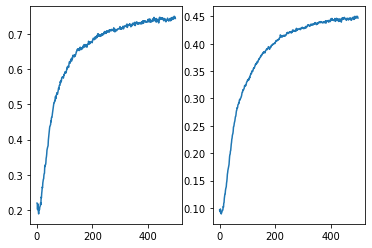

In [75]:
plt.subplot(1, 2, 1)
plt.plot(hit_ratio_hist)

plt.subplot(1, 2, 2)
plt.plot(ndcg_hist)